
# Project 1 — Parts c)–f)
This notebook solves **c, d, e, f**. 


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import sys, pathlib

# Project-1 folder (parent of this Notebooks/ folder)
proj_dir = pathlib.Path.cwd().parent
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))

# Figures folder
fig_dir = proj_dir / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

from Code.data import make_data, build_features, split_and_scale

# --- Project-wide experiment config (new variables added on as they are introduced) ---

# Data settings
N_SAMPLES   = 300     # number of samples
NOISE_SD    = 0.3     # noise standard deviation
SEED_DATA   = 42      # data generation
SEED_SPLIT  = 42      # train/test split (split_and_scale uses this)
DEG_MAX     = 15      # max polynomial degree for features
P_FIXED     = 15      # fixed polynomial degree for regularization experiments
TEST_SIZE   = 0.20    # train/test split size


# Regularization grids
LAM_GRID_RIDGE = np.logspace(-6, 1, 40)  # wider range for ridge
LAM_GRID_LASSO = np.logspace(-6, 0, 60)  # less range for LASSO

# Optimizer settings
LAM_RIDGE  = 1e-4   # since n_factor=True, this gives α=0.03.. (see alpha_from_lambda)
BETA = 0.3    # momentum parameter
B1 = 0.9    # Adam parameter
B2 = 0.999  # Adam parameter
EPS = 1e-8  # Adam parameter
RHO = 0.99  # Adadelta parameter

# Mini-batch SGD
EPOCHS_MB    = 25     # passes over data
BATCH_SIZE   = 64     # minibatch size
ETA_MB_OLS   = 1e-2   # for OLS, can be larger
ETA_MB_RIDGE = 1e-2   # for ridge, need to tune
SEED_MB      = 42     # minibatch shuffle

# --- Generate data explicitly---
x, y = make_data(n=N_SAMPLES, noise_sd=NOISE_SD, seed=SEED_DATA)
X_full = build_features(x, degree=DEG_MAX, include_bias=False)


X_tr_s, X_te_s, y_tr_c, y_te, scaler, y_mean = split_and_scale(X_full, y, test_size=TEST_SIZE, random_state=SEED_SPLIT)

Xtr_p = X_tr_s[:, :P_FIXED]
Xte_p = X_te_s[:, :P_FIXED]
p = Xtr_p.shape[1]
theta0 = np.zeros(p)


## c) Gradient Descent for OLS and Ridge (using `grad.py`)

We first use the plain gradient descent method. We run a code to find the best eta value from a selection, the code picks the largest one that keeps the loss non increasing and reaches within 1% of the final loss within the fewest iterations. The outcome depends on our range of eta values chosen and number of iterations. 


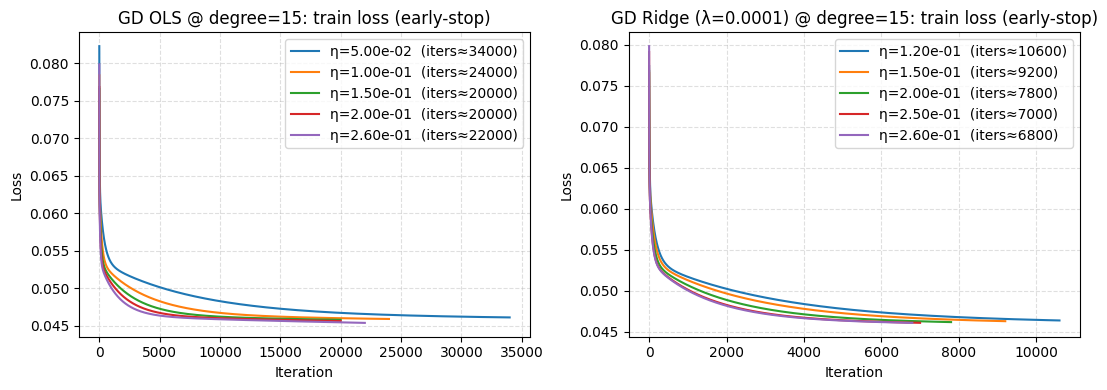

Chosen η — OLS:  0.26
Chosen η — Ridge:0.26


In [ ]:
from Code.grad    import gd, loss_ols, loss_ridge, grad_ols, grad_ridge
from Code.models  import predict_centered
from Code.metrics import mse, r2

# ---- early-stop helper ----

def plateaued(losses, window=2000, rel_tol=1e-4, abs_tol=1e-8, use_avg=True):
    """
    Return True if the loss has effectively stopped improving.
    - Compare the last `window` iters to the previous `window`.
    - If use_avg=True, compare windowed means (smoother).
    """
    n = len(losses)
    if n < 2*window:
        return False
    recent = losses[-window:]
    prev   = losses[-2*window:-window]

    if use_avg:
        L_new = float(np.mean(recent))
        L_old = float(np.mean(prev))
    else:
        L_new = float(recent[-1])
        L_old = float(prev[-1])

    improvement = L_old - L_new                      # positive if loss decreased
    thresh = max(abs_tol, rel_tol * max(1.0, L_old))  # relative OR absolute
    return improvement <= thresh


def run_gd_with_early_stop(
    X, y_c, *, eta, lam=None, n_factor=True, theta0=None,
    chunk=2000, max_iters=200_000, window=2000, rel_tol=1e-4, abs_tol=1e-8,
    every=1
):
    p = X.shape[1]
    theta = np.zeros(p) if theta0 is None else np.asarray(theta0, float).ravel()
    losses = []
    done = 0
    while done < max_iters:
        take = min(chunk, max_iters - done)
        theta, L = gd(X, y_c, eta, take, theta0=theta,
                      lam=lam, n_factor=n_factor,
                      track_loss=True, every=every)
        # avoid duplicating the first point of the chunk
        losses.extend(L[1:] if len(L) > 1 else L)
        done += take
        if plateaued(losses, window=window, rel_tol=rel_tol, abs_tol=abs_tol, use_avg=True):
            break
    return theta, np.asarray(losses), done


# ---------------- experiment config ----------

# Iter caps for OLS / Ridge
MAX_ITERS_OLS   = 800_000   # OLS needs many iters at p=15 (ill-conditioned)
MAX_ITERS_RIDGE = 20_000    #needs less than OLS

# Chunk size and plateau params
CHUNK     = 2000
WINDOW    = 2000
TOL       = 1e-6
EVERY     = 1

# Ridge: small window, tighter tol (it converges fast)
RIDGE_WINDOW  = 400
RIDGE_RTOL    = 5e-5

# OLS: larger window, looser tol (slow drift)
OLS_WINDOW    = 5000
OLS_RTOL      = 2e-4

eta_list_ols   = [0.05, 0.1, 0.15, 0.20, 0.26]
eta_list_ridge = [0.12, 0.15, 0.20, 0.25,0.26]

fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=False)

# -------- OLS (lam=None) ----------
best_eta_ols, best_mse_ols = None, np.inf
for eta in eta_list_ols:
    th, Ls, used = run_gd_with_early_stop(
        Xtr_p, y_tr_c, eta=eta, lam=None, n_factor=True,
        chunk=2000, max_iters=800_000, window=OLS_WINDOW, rel_tol=OLS_RTOL
    )
    axes[0].plot(Ls, label=f"η={eta:.2e}  (iters≈{len(Ls)})")
    m = mse(y_te, predict_centered(Xte_p, th, y_mean))
    if m < best_mse_ols:
        best_mse_ols, best_eta_ols = m, eta

axes[0].set_title(f"GD OLS @ degree={P_FIXED}: train loss (early-stop)")
axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Loss")
axes[0].legend(); axes[0].grid(True, ls='--', alpha=0.4)

# -------- Ridge (lam=LAM_RIDGE, α=λ/n via n_factor=True) ----------
best_eta_rdg, best_mse_rdg = None, np.inf
for eta in eta_list_ridge:
    th, Ls, used = run_gd_with_early_stop(
        Xtr_p, y_tr_c, eta=eta, lam=LAM_RIDGE, n_factor=True,
        chunk=200, max_iters=20_000, window=RIDGE_WINDOW, rel_tol=RIDGE_RTOL
    )
    axes[1].plot(Ls, label=f"η={eta:.2e}  (iters≈{len(Ls)})")
    m = mse(y_te, predict_centered(Xte_p, th, y_mean))
    if m < best_mse_rdg:
        best_mse_rdg, best_eta_rdg = m, eta

axes[1].set_title(f"GD Ridge (λ={LAM_RIDGE}) @ degree={P_FIXED}: train loss (early-stop)")
axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("Loss")
axes[1].legend(); axes[1].grid(True, ls='--', alpha=0.4)
fig.tight_layout(); plt.show()

print(f"Chosen η — OLS:  {best_eta_ols}")
print(f"Chosen η — Ridge:{best_eta_rdg}")


In [ ]:
from Code.models import fit_ols, fit_ridge
# closed-form baselines
theta_cf_ols   = fit_ols(Xtr_p, y_tr_c)
theta_cf_ridge = fit_ridge(Xtr_p, y_tr_c, lam=LAM_RIDGE)

# GD with the fastest stable η found above
ETA_OLS= 0.26
ETA_RIDGE = 0.26
ITERS_OLS = 22000
ITERS_RIDGE = 6800
theta_gd_ols,  _ = gd(Xtr_p, y_tr_c, ETA_OLS, ITERS_OLS, theta0=np.zeros(Xtr_p.shape[1]), lam=None, track_loss=True)
theta_gd_rdg,  _ = gd(Xtr_p, y_tr_c, ETA_RIDGE, ITERS_RIDGE, theta0=np.zeros(Xtr_p.shape[1]), lam=LAM_RIDGE, n_factor=True, track_loss=True)

# test metrics (original y-scale)
yhat_cf_ols = predict_centered(Xte_p, theta_cf_ols, y_mean)
yhat_cf_rdg = predict_centered(Xte_p, theta_cf_ridge, y_mean)
yhat_gd_ols = predict_centered(Xte_p, theta_gd_ols,  y_mean)
yhat_gd_rdg = predict_centered(Xte_p, theta_gd_rdg,  y_mean)

print("CF  OLS  MSE/R²:", mse(y_te, yhat_cf_ols),  r2(y_te, yhat_cf_ols))
print("GD  OLS  MSE/R²:", mse(y_te, yhat_gd_ols),  r2(y_te, yhat_gd_ols))
print("CF  Ridge MSE/R²:", mse(y_te, yhat_cf_rdg), r2(y_te, yhat_cf_rdg))
print("GD  Ridge MSE/R²:", mse(y_te, yhat_gd_rdg), r2(y_te, yhat_gd_rdg))



print("Ridge TRAIN | CF:", loss_ridge(Xtr_p, y_tr_c, theta_cf_ridge, LAM_RIDGE, True),
      " GD:",           loss_ridge(Xtr_p, y_tr_c, theta_gd_rdg,   LAM_RIDGE, True))


CF  OLS  MSE/R²: 0.1351492510020802 0.32147733207080154
GD  OLS  MSE/R²: 0.13038979575070378 0.3453723832909068
CF  Ridge MSE/R²: 0.12625328341116895 0.36613992264264184
GD  Ridge MSE/R²: 0.13252339606411231 0.3346605505118537
Ridge TRAIN | CF: 0.04251260724044948  GD: 0.04610437460882058



## d) Optimizers: Momentum, AdaGrad, RMSProp, Adam

We keep the same objectives but change the update rule. We'll use both Ridge and OLS. 


In [ ]:
from Code.grad import grad_ols, grad_ridge

# --- Function for optimizers ---
def run_optimizer(X, y, lam=None, eta=1e-3, iters=1000, optimizer="gd",
                  beta=0.9, eps=1e-8, rho=0.99, b1=0.9, b2=0.999):
    """
    Full-batch optimizers for OLS (lam=None) and Ridge (lam=float).
    Uses α = λ/n for Ridge (n_factor=True). 
    """
    n, p = X.shape
    theta = np.zeros(p, float)
    v = np.zeros_like(theta)  # momentum
    s = np.zeros_like(theta)  # 2nd moment
    m = np.zeros_like(theta)  # 1st moment
    t = 0

    for _ in range(iters):
        g = grad_ols(X, y, theta) if lam is None else grad_ridge(X, y, theta, lam, n_factor=True)
        t += 1

        if optimizer == "gd":
            theta -= eta * g

        elif optimizer == "momentum":
            v = beta * v + (1 - beta) * g
            theta -= eta * v

        elif optimizer == "adagrad":
            s += g * g
            theta -= (eta / (np.sqrt(s) + eps)) * g

        elif optimizer == "rmsprop":
            s = rho * s + (1 - rho) * (g * g)
            theta -= (eta / (np.sqrt(s) + eps)) * g    

        elif optimizer == "adam":
            m = b1 * m + (1 - b1) * g
            s = b2 * s + (1 - b2) * (g * g)
            m_hat = m / (1 - b1**t)
            s_hat = s / (1 - b2**t)
            theta -= eta * m_hat / (np.sqrt(s_hat) + eps)  

        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")

    return theta


# --- Run comparisons ---

# Use fixed degree p 
Xtr, Xte = Xtr_p, Xte_p

#can't use the same eta for all optimizers, need a smaller eta for the optimizers that are more "aggressive" (like Adam and RMSProp)
configs = {
  "gd":       dict(eta=0.26, iters=1000),
  "momentum": dict(eta=0.26, iters=1000, beta=BETA),
  "adagrad":  dict(eta=1e-2, iters=2000),
  "rmsprop":  dict(eta=1e-3, iters=2000, rho=RHO),
  "adam":     dict(eta=1e-3, iters=2000, b1=B1, b2=B2),
}

# --- RIDGE ---
ridge_results = {}
for opt, kw in configs.items():
    th = run_optimizer(Xtr, y_tr_c, lam=LAM_RIDGE, optimizer=opt, **kw)
    yhat = predict_centered(Xte, th, y_mean)
    ridge_results[opt] = (mse(y_te, yhat), r2(y_te, yhat))

print(f"FULL-BATCH (RIDGE, λ={LAM_RIDGE})")
for k, (mse_v, r2_v) in ridge_results.items():
    print(f"{k:8s}  MSE={mse_v:.5f}  R²={r2_v:.4f}")

# --- OLS ---
ols_results = {}
for opt, kw in configs.items():
    th = run_optimizer(Xtr, y_tr_c, lam=None, optimizer=opt, **kw)  # lam=None => OLS
    yhat = predict_centered(Xte, th, y_mean)
    ols_results[opt] = (mse(y_te, yhat), r2(y_te, yhat))

print("FULL-BATCH (OLS, λ=None)")
for k, (mse_v, r2_v) in ols_results.items():
    print(f"{k:8s}  MSE={mse_v:.5f}  R²={r2_v:.4f}")


FULL-BATCH (RIDGE, λ=0.0001)
gd        MSE=0.14241  R²=0.2850
momentum  MSE=0.14242  R²=0.2850
adagrad   MSE=0.14960  R²=0.2489
rmsprop   MSE=0.14116  R²=0.2913
adam      MSE=0.14416  R²=0.2762
FULL-BATCH (OLS, λ=None)
gd        MSE=0.14241  R²=0.2850
momentum  MSE=0.14242  R²=0.2850
adagrad   MSE=0.14960  R²=0.2489
rmsprop   MSE=0.14088  R²=0.2927
adam      MSE=0.14416  R²=0.2763



## e) LASSO 



In [49]:
def soft_threshold(z, tau):
    # elementwise shrinkage: sign(z)*max(|z|-tau, 0)
    return np.sign(z) * np.maximum(np.abs(z) - tau, 0.0)

def lasso_ista(X, y_c, theta0, eta, lam, iters):
    """
    Minimizes: (1/n)||Xθ - y_c||^2 + lam * ||θ||_1
    Proximal step matches sklearn if you set alpha = lam/2 there.
    """
    n = X.shape[0]
    theta = theta0.copy()
    for _ in range(iters):
        grad = (2.0/n) * (X.T @ (X @ theta - y_c))     # gradient of (1/n)||r||^2
        theta = soft_threshold(theta - eta*grad, eta*lam)
    return theta

from Code.models import fit_lasso_skl
""" from Code.grad import lasso_gd, lasso_ista """

# --- Compare LASSO: scikit vs. GD at λ=2.73e-05 (best lambda value from tests above)---
lam = LAM_RIDGE #use same lambda as ridge for simplicity

# sklearn baseline (coordinate descent)
theta_skl = fit_lasso_skl(Xtr, y_tr_c, lam)

# proximal gradient (ISTA)
theta0 = np.zeros(Xtr.shape[1])
theta_pg = lasso_ista(Xtr, y_tr_c, theta0, eta=1e-3, lam=lam, iters=5000)

# predictions (remember + y_mean)
yhat_skl = Xte @ theta_skl + y_mean
yhat_pg  = Xte @ theta_pg  + y_mean

print("SKL  MSE/R²:", mse(y_te, yhat_skl), r2(y_te, yhat_skl))
print("ISTA MSE/R²:", mse(y_te, yhat_pg),  r2(y_te, yhat_pg))




SKL  MSE/R²: 0.12913859860045612 0.351654072772696
ISTA MSE/R²: 0.15378708005216485 0.22790530412610277


/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+00, tolerance: 4.234e-05
  model = cd_fast.enet_coordinate_descent(


We add the optimizers from part d). 

In [ ]:
# --- Proximal optimizers for Lasso (1/n)||Xθ - y_c||^2 + λ||θ||_1 ---
def soft_threshold(z, tau): 
    # tau can be scalar or per-coordinate array
    return np.sign(z) * np.maximum(np.abs(z) - tau, 0.0)

 # Gradient of the smooth part of Lasso: (1/n)||Xθ - y_c||^2
def grad_smooth_lasso(X, y_c, theta):
    # gradient of (1/n)||Xθ - y_c||^2
    n = X.shape[0]
    return (2.0/n) * (X.T @ (X @ theta - y_c))

# Proximal optimizers for Lasso
def run_prox_optimizer_lasso(
    X, y_c, lam, optimizer="pgd",
    eta=1e-3, iters=5000,
    beta=0.9,           # momentum / FISTA
    rho=0.99,           # RMSProp
    b1=0.9, b2=0.999,   # Adam
    eps=1e-8,           #epsilon means 
    theta0=None,  
    nesterov=True       # for FISTA
):
    """
    Proximal optimizers for Lasso:
      - 'pgd'    : proximal GD (ISTA)
      - 'fista'  : accelerated proximal GD (Nesterov)
      - 'adagrad': proximal AdaGrad
      - 'rmsprop': proximal RMSProp
      - 'adam'   : proximal Adam 

    All use scaling: (1/n)||Xθ - y||^2 + lam * ||θ||_1
    """
    p = X.shape[1]
    theta = np.zeros(p) if theta0 is None else np.asarray(theta0, float).copy()

    # state for adaptive methods / momentum
    s_adagrad = np.zeros(p)
    v_rms     = np.zeros(p)
    m_adam    = np.zeros(p)
    v_adam    = np.zeros(p)
    t = 0

    # FISTA variables
    yk = theta.copy()
    tk = 1.0

    for _ in range(iters):
        t += 1

        # choose the point to evaluate the gradient at (FISTA uses yk, others use theta)
        if optimizer == "fista":
            grad = grad_smooth_lasso(X, y_c, yk)
        else:
            grad = grad_smooth_lasso(X, y_c, theta)

        if optimizer == "pgd":  # ISTA
            step = eta                       # scalar step
            theta = soft_threshold(theta - step * grad, lam * step)

        elif optimizer == "fista":
            step = eta
            z = yk - step * grad
            theta_next = soft_threshold(z, lam * step)
            if nesterov:
                tk_next = 0.5 * (1 + np.sqrt(1 + 4 * tk * tk))
                yk = theta_next + ((tk - 1) / tk_next) * (theta_next - theta)
                tk = tk_next
                theta = theta_next
            else:
                theta = theta_next

        elif optimizer == "adagrad":
            s_adagrad += grad * grad
            step_i = eta / (np.sqrt(s_adagrad) + eps)  # element-wise
            theta = soft_threshold(theta - step_i * grad, lam * step_i)

        elif optimizer == "rmsprop":
            v_rms = rho * v_rms + (1 - rho) * (grad * grad)
            step_i = eta / (np.sqrt(v_rms) + eps)      # element-wise
            theta = soft_threshold(theta - step_i * grad, lam * step_i)

        elif optimizer == "adam":
            m_adam = b1 * m_adam + (1 - b1) * grad
            v_adam = b2 * v_adam + (1 - b2) * (grad * grad)
            m_hat = m_adam / (1 - b1**t)
            v_hat = v_adam / (1 - b2**t)
            step_i = eta / (np.sqrt(v_hat) + eps)      # element-wise effective step
            theta = soft_threshold(theta - step_i * m_hat, lam * step_i)

        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")

    return theta


In [40]:
"""Helpers for Lasso experiments
"""
Xtr, Xte = Xtr_p, Xte_p
# safe step for ISTA / FISTA:
n = Xtr.shape[0]
smax = np.linalg.svd(Xtr, compute_uv=False)[0] # largest singular value
L = (2.0/n) * (smax**2) # Lipschitz constant of ∇f
ETA_ISTA = 1.0 / L # safe step for ISTA / FISTA


In [41]:
# Configs for different optimizers, we can't use the same eta for all optimizers, need a smaller eta for the optimizers that 
# are more "aggressive" (like Adam and RMSProp)
cfgs = {
    "pgd":    dict(eta=ETA_ISTA, iters=5000),
    "fista":  dict(eta=ETA_ISTA, iters=3000, beta=0.0),  # beta unused; nesterov=True inside
    "adagrad":dict(eta=1e-2,     iters=5000),
    "rmsprop":dict(eta=1e-3,     iters=5000, rho=RHO),
    "adam":   dict(eta=1e-3,     iters=5000, b1=B1, b2=B2),
}


In [42]:

lam = LAM_RIDGE

# sklearn baseline (coordinate descent)
theta_skl = fit_lasso_skl(Xtr, y_tr_c, lam)

# proximal optimizers
theta_pgd   = run_prox_optimizer_lasso(Xtr, y_tr_c, lam, optimizer="pgd",   **cfgs["pgd"])
theta_fista = run_prox_optimizer_lasso(Xtr, y_tr_c, lam, optimizer="fista", **cfgs["fista"])
theta_rms   = run_prox_optimizer_lasso(Xtr, y_tr_c, lam, optimizer="rmsprop", **cfgs["rmsprop"])
theta_adam  = run_prox_optimizer_lasso(Xtr, y_tr_c, lam, optimizer="adam", **cfgs["adam"])

# predictions (+ y_mean)
yhat_skl   = Xte @ theta_skl   + y_mean
yhat_pgd   = Xte @ theta_pgd   + y_mean
yhat_fista = Xte @ theta_fista + y_mean
yhat_rms   = Xte @ theta_rms   + y_mean
yhat_adam  = Xte @ theta_adam  + y_mean


print("ISTA  MSE/R²:", mse(y_te, yhat_pg),    r2(y_te, yhat_pg))
print("SKL   MSE/R²:", mse(y_te, yhat_skl),   r2(y_te, yhat_skl))
print("PGD   MSE/R²:", mse(y_te, yhat_pgd),   r2(y_te, yhat_pgd))
print("FISTA MSE/R²:", mse(y_te, yhat_fista), r2(y_te, yhat_fista))
print("RMSPr MSE/R²:", mse(y_te, yhat_rms),   r2(y_te, yhat_rms))
print("Adam  MSE/R²:", mse(y_te, yhat_adam),  r2(y_te, yhat_adam))


/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+00, tolerance: 4.234e-05
  model = cd_fast.enet_coordinate_descent(


ISTA  MSE/R²: 0.15329294251685296 0.23038614302308358
SKL   MSE/R²: 0.12913859860045612 0.351654072772696
PGD   MSE/R²: 0.13712411356944226 0.31156244902065877
FISTA MSE/R²: 0.12873283597248183 0.35369122161989763
RMSPr MSE/R²: 0.13419500136327753 0.3262681837106741
Adam  MSE/R²: 0.13377767634299617 0.3283633820492172



## f) Stochastic Gradient Descent

We test SGD on Ridge. We test with different batch sizes, and plot loss vs epochs for plain GD and SGD. We evaluate with MSE and $R^2$. 



In [50]:
def sgd_minibatch(
    X, y_c, lam=None, n_factor=True,
    epochs=25, batch_size=64, eta=1e-3, optimizer="sgd",
    beta=0.9, eps=1e-8, rho=0.99, b1=0.9, b2=0.999, seed=42
):
    """
    Mini-batch SGD for OLS (lam=None) or Ridge (lam=float):
      loss(θ) = (1/(2n))||Xθ - y||^2 + (α/2)||θ||^2, with α = lam/n if n_factor=True.
    Gradient per batch b (size nb):
      g_b = (X_b^T r_b)/nb  +  α * θ
    """
    n, p = X.shape
    rng = np.random.default_rng(seed)
    theta = np.zeros(p, float)

    # states for the optimizers
    v = np.zeros_like(theta)  # momentum
    s = np.zeros_like(theta)  # second moment (AdaGrad/RMSProp/Adam)
    m = np.zeros_like(theta)  # first moment  (Adam)
    t = 0

    # ridge scaling
    alpha = 0.0
    if lam is not None:
        alpha = (lam / n) if n_factor else lam

    for _ in range(epochs):
        idx = rng.permutation(n)
        for start in range(0, n, batch_size):
            b = idx[start:start+batch_size]
            Xb, yb = X[b], y_c[b]
            nb = Xb.shape[0]

            # batch gradient for the (1/(2n)) convention: (Xb^T r)/nb  +  α θ
            r = Xb @ theta - yb
            g = (Xb.T @ r) / nb
            if lam is not None:
                g = g + alpha * theta

            t += 1
            if optimizer == "sgd":
                theta -= eta * g

            elif optimizer == "momentum":
                v = beta * v + (1 - beta) * g
                theta -= eta * v

            elif optimizer == "adagrad":
                s += g * g
                theta -= (eta / (np.sqrt(s) + eps)) * g

            elif optimizer == "rmsprop":
                s = rho * s + (1 - rho) * (g * g)
                theta -= (eta / (np.sqrt(s) + eps)) * g

            elif optimizer == "adam":
                m = b1 * m + (1 - b1) * g
                s = b2 * s + (1 - b2) * (g * g)
                m_hat = m / (1 - b1**t)
                s_hat = s / (1 - b2**t)
                theta -= eta * m_hat / (np.sqrt(s_hat) + eps)

            else:
                raise ValueError(f"Unknown optimizer: {optimizer}")

    return theta


theta_full = run_optimizer(X_tr_s, y_tr_c, lam=LAM_RIDGE, eta=5e-3, iters=5000, optimizer="adam")
theta_sgd  = sgd_minibatch(X_tr_s, y_tr_c, lam=LAM_RIDGE, epochs=EPOCHS_MB, batch_size=BATCH_SIZE, eta=5e-3, optimizer="adam")

yhat_full = predict_centered(X_te_s, theta_full, y_mean)
yhat_sgd  = predict_centered(X_te_s, theta_sgd,  y_mean)
print("Full-batch Adam:", mse(y_te, yhat_full), r2(y_te, yhat_full))
print("Mini-batch Adam:", mse(y_te, yhat_sgd),  r2(y_te, yhat_sgd))


Full-batch Adam: 0.12921996727823018 0.3512455578018785
Mini-batch Adam: 0.15646818944201474 0.2144446783163233


In [ ]:

from Code.metrics import mse, r2
from Code.models  import predict_centered
from Code.grad    import loss_ridge  # for loss tracking

# Use fixed-degree design for fair comparison
Xtr, Xte = Xtr_p, Xte_p

# ----- traced versions (per-epoch loss) -----

def fullbatch_adam_with_trace(X, y_c, lam, eta=1e-3, epochs=25, b1=0.9, b2=0.999, eps=1e-8):
    """
    Full-batch Adam for Ridge with α=λ/n (same scaling as earlier).
    Returns (theta, train_losses_per_epoch). 
    """
    n, p = X.shape
    alpha = lam / n
    theta = np.zeros(p)
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)
    losses = []
    t = 0
    for ep in range(epochs):
        # full gradient: (X^T r)/n + α θ   with 1/(2n) convention
        r = X @ theta - y_c
        g = (X.T @ r) / n + alpha * theta
        t += 1
        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * (g * g)
        m_hat = m / (1 - b1**t)
        v_hat = v / (1 - b2**t)
        theta -= eta * m_hat / (np.sqrt(v_hat) + eps)

        # record train objective (same loss as parts b–d)
        losses.append(loss_ridge(X, y_c, theta, lam, n_factor=True))
    return theta, np.array(losses)

def minibatch_adam_with_trace(X, y_c, lam, eta=1e-3, epochs=25, batch_size=64,
                              b1=0.9, b2=0.999, eps=1e-8, rho=0.99, seed=42):
    """
    Mini-batch Adam for Ridge with α=λ/n (same scaling).
    Returns (theta, train_losses_per_epoch).
    """
    n, p = X.shape
    alpha = lam / n
    rng = np.random.default_rng(seed)
    theta = np.zeros(p)
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)
    t = 0
    losses = []

    for ep in range(epochs):
        idx = rng.permutation(n)
        for start in range(0, n, batch_size):
            b = idx[start:start+batch_size]
            Xb, yb = X[b], y_c[b]
            nb = Xb.shape[0]
            # batch gradient matches 1/(2n) convention: (Xb^T r)/nb + α θ
            r = Xb @ theta - yb
            g = (Xb.T @ r) / nb + alpha * theta

            t += 1
            m = b1 * m + (1 - b1) * g
            v = b2 * v + (1 - b2) * (g * g)
            m_hat = m / (1 - b1**t)
            v_hat = v / (1 - b2**t)
            theta -= eta * m_hat / (np.sqrt(v_hat) + eps)

        # end of epoch: record full train objective
        losses.append(loss_ridge(X, y_c, theta, lam, n_factor=True))
    return theta, np.array(losses)

# ----- Table: test MSE/R² vs batch size for Adam -----


# Use fixed-degree design for fair comparison
Xtr, Xte = Xtr_p, Xte_p

ETA_ADAM    = 1e-3
EPOCHS_ADAM = 25
batch_sizes = [16, 32, 64, 128]

rows = []
for bs in batch_sizes:
    theta_mb, _ = minibatch_adam_with_trace(
        Xtr, y_tr_c, lam=LAM_RIDGE,
        eta=ETA_ADAM, epochs=EPOCHS_ADAM, batch_size=bs,
        b1=0.9, b2=0.999, eps=1e-8, seed=42
    )
    yhat = predict_centered(Xte, theta_mb, y_mean)
    rows.append((bs, mse(y_te, yhat), r2(y_te, yhat)))

# Pretty print 
w1, w2, w3 = 10, 14, 10
print(f"{'Batch size':<{w1}} {'Test MSE':<{w2}} {'Test R²':<{w3}}")
print("-"*(w1+w2+w3+2))
for bs, m, r in rows:
    print(f"{bs:<{w1}d} {m:<{w2}.6f} {r:<{w3}.4f}")

# save csv:
import csv
out_csv = fig_dir / "sgd_adam_batch_table.csv"   # save under Figures/
with open(out_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["batch_size", "test_mse", "test_r2"])
    writer.writerows(rows)

print(f"Saved CSV → {out_csv}")





Batch size Test MSE       Test R²   
------------------------------------
16         0.157219       0.2107    
32         0.159495       0.1992    
64         0.165612       0.1685    
128        0.172847       0.1322    
Saved CSV → /Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/Project-1/Figures/sgd_adam_batch_table.csv


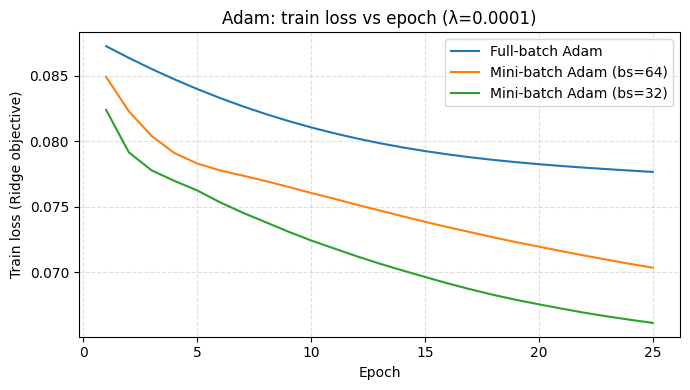

<Figure size 640x480 with 0 Axes>

In [45]:
# Full-batch Adam (same η/epochs)
theta_full, L_full = fullbatch_adam_with_trace(
    Xtr, y_tr_c, lam=LAM_RIDGE,
    eta=ETA_ADAM, epochs=EPOCHS_ADAM
)

# Mini-batch Adam, two batch sizes to show noise/speed
theta_mb64, L_mb64 = minibatch_adam_with_trace(
    Xtr, y_tr_c, lam=LAM_RIDGE,
    eta=ETA_ADAM, epochs=EPOCHS_ADAM, batch_size=64
)
theta_mb32, L_mb32 = minibatch_adam_with_trace(
    Xtr, y_tr_c, lam=LAM_RIDGE,
    eta=ETA_ADAM, epochs=EPOCHS_ADAM, batch_size=32
)

import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
epochs = range(1, EPOCHS_ADAM+1)
plt.plot(epochs, L_full,  label="Full-batch Adam")
plt.plot(epochs, L_mb64,  label="Mini-batch Adam (bs=64)")
plt.plot(epochs, L_mb32,  label="Mini-batch Adam (bs=32)")
plt.xlabel("Epoch")
plt.ylabel("Train loss (Ridge objective)")
plt.title(f"Adam: train loss vs epoch (λ={LAM_RIDGE})")
plt.grid(True, ls="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.savefig(fig_dir / "adam_train_loss_vs_epoch.png", dpi=300, bbox_inches="tight")

Below are some codes from chatgpt to make a table of everything we've tested so far for comparison. Not sure if I'll use or not. 

In [47]:
import time, math, csv, numpy as np
from Code.metrics import mse, r2
from Code.models  import fit_ols, fit_ridge, predict_centered

# --- (If not already defined) Lasso helpers from the previous message ---
def soft_threshold(z, tau): return np.sign(z) * np.maximum(np.abs(z) - tau, 0.0)
def grad_smooth_lasso(X, y_c, theta): return (2.0/X.shape[0]) * (X.T @ (X @ theta - y_c))
def ista_step_from_X(X):
    n = X.shape[0]; smax = np.linalg.svd(X, compute_uv=False)[0]
    return 1.0 / ((2.0/n) * (smax**2))
def run_prox_lasso(X, y_c, lam, optimizer="pgd", eta=1e-3, iters=3000, b1=0.9, b2=0.999, rho=0.99, eps=1e-8):
    p = X.shape[1]; theta = np.zeros(p); s_ad=np.zeros(p); v_r=np.zeros(p); m=np.zeros(p); v=np.zeros(p); t=0
    yk=theta.copy(); tk=1.0
    for _ in range(iters):
        t+=1
        g = grad_smooth_lasso(X,y_c, yk if optimizer=="fista" else theta)
        if optimizer=="pgd":
            step=eta; theta=soft_threshold(theta - step*g, lam*step)
        elif optimizer=="fista":
            step=eta; z=yk - step*g; th_next=soft_threshold(z, lam*step)
            tk_next = 0.5*(1+np.sqrt(1+4*tk*tk)); yk = th_next + ((tk-1)/tk_next)*(th_next-theta); tk=tk_next; theta=th_next
        elif optimizer=="adagrad":
            s_ad += g*g; step_i = eta/(np.sqrt(s_ad)+1e-8); theta = soft_threshold(theta - step_i*g, lam*step_i)
        elif optimizer=="rmsprop":
            v_r = 0.99*v_r + 0.01*(g*g); step_i = eta/(np.sqrt(v_r)+1e-8); theta = soft_threshold(theta - step_i*g, lam*step_i)
        elif optimizer=="adam":
            m = 0.9*m + 0.1*g; v = 0.999*v + 0.001*(g*g)
            m_hat=m/(1-0.9**t); v_hat=v/(1-0.999**t); step_i = eta/(np.sqrt(v_hat)+1e-8)
            theta = soft_threshold(theta - step_i*m_hat, lam*step_i)
        else: raise ValueError("unknown optimizer")
    return theta

def prox_minibatch_adam_lasso(X, y_c, lam, eta=1e-3, epochs=25, batch_size=64, b1=0.9, b2=0.999, eps=1e-8, seed=42):
    n,p = X.shape; rng=np.random.default_rng(seed); theta=np.zeros(p); m=np.zeros(p); v=np.zeros(p); t=0
    for _ in range(epochs):
        idx = rng.permutation(n)
        for start in range(0,n,batch_size):
            b = idx[start:start+batch_size]; Xb,yb=X[b],y_c[b]; nb=Xb.shape[0]
            g = (2.0/nb) * (Xb.T @ (Xb@theta - yb))
            t+=1; m= b1*m + (1-b1)*g; v = b2*v + (1-b2)*(g*g)
            m_hat=m/(1-b1**t); v_hat=v/(1-b2**t); step_i = eta/(np.sqrt(v_hat)+eps)
            theta = soft_threshold(theta - step_i*m_hat, lam*step_i)
    return theta

# ---------- config ----------
Xtr, Xte = Xtr_p, Xte_p
ETA_ISTA  = ista_step_from_X(Xtr)
def lasso_lambda_default(X,y_c,frac=1e-3):
    lam_max = (2.0/X.shape[0]) * np.max(np.abs(X.T @ y_c)); return lam_max*frac
LASSO_LAM = lasso_lambda_default(Xtr, y_tr_c)  # replace with your tuned λ if you have one

METHODS = [
    # Closed-form
    ("OLS  (CF)",            dict(kind="cf",   model="ols")),
    ("Ridge(CF)",            dict(kind="cf",   model="ridge", lam=LAM_RIDGE)),

    # Full-batch OLS / Ridge
    ("GD OLS (full)",        dict(kind="full_lr", model="ols",   opt="gd",       eta=0.26, iters=1000)),
    ("Adam OLS (full)",      dict(kind="full_lr", model="ols",   opt="adam",     eta=1e-3, iters=2000, b1=0.9, b2=0.999)),
    ("GD Ridge (full)",      dict(kind="full_lr", model="ridge", opt="gd",       eta=0.26, iters=1000)),
    ("Adam Ridge (full)",    dict(kind="full_lr", model="ridge", opt="adam",     eta=1e-3, iters=2000, b1=0.9, b2=0.999)),

    # Mini-batch Ridge
    ("Adam Ridge (mb,64)",   dict(kind="mb_ridge", opt="adam", eta=1e-3, epochs=25, batch_size=64, b1=0.9, b2=0.999)),

    # LASSO (prox)
    ("Lasso ISTA (full)",    dict(kind="lasso_full", opt="pgd",   lam=LASSO_LAM, eta=ETA_ISTA, iters=4000)),
    ("Lasso FISTA (full)",   dict(kind="lasso_full", opt="fista", lam=LASSO_LAM, eta=ETA_ISTA, iters=2500)),
    ("Lasso Adam (full)",    dict(kind="lasso_full", opt="adam",  lam=LASSO_LAM, eta=1e-3,    iters=4000, b1=0.9, b2=0.999)),
    ("Lasso Adam (mb,64)",   dict(kind="lasso_mb",   lam=LASSO_LAM, eta=1e-3, epochs=25, batch_size=64, b1=0.9, b2=0.999)),
]

# ---------- training + timing with metadata ----------
def train_and_eval(name, cfg):
    meta = dict(name=name, optimizer="-", eta=np.nan, lam=np.nan, iters=0, epochs=0, batch_size=0)
    t0 = time.perf_counter()

    if cfg["kind"] == "cf":
        if cfg["model"] == "ols":
            theta = fit_ols(Xtr, y_tr_c)
        else:
            theta = fit_ridge(Xtr, y_tr_c, lam=cfg.get("lam", LAM_RIDGE))
            meta["lam"] = cfg.get("lam", LAM_RIDGE)

    elif cfg["kind"] == "full_lr":
        lam = None if cfg["model"]=="ols" else LAM_RIDGE
        theta = run_optimizer(Xtr, y_tr_c, lam=lam, optimizer=cfg["opt"],
                              eta=cfg["eta"], iters=cfg["iters"],
                              beta=cfg.get("beta", 0.9), eps=1e-8,
                              rho=cfg.get("rho",0.99), b1=cfg.get("b1",0.9), b2=cfg.get("b2",0.999))
        meta.update(optimizer=cfg["opt"], eta=cfg["eta"], iters=cfg["iters"], lam=(lam or np.nan))

    elif cfg["kind"] == "mb_ridge":
        theta = sgd_minibatch(Xtr, y_tr_c, lam=LAM_RIDGE, n_factor=True,
                              epochs=cfg["epochs"], batch_size=cfg["batch_size"],
                              eta=cfg["eta"], optimizer=cfg["opt"],
                              beta=0.9, eps=1e-8, rho=cfg.get("rho",0.99),
                              b1=cfg.get("b1",0.9), b2=cfg.get("b2",0.999), seed=42)
        meta.update(optimizer=cfg["opt"], eta=cfg["eta"], lam=LAM_RIDGE,
                    epochs=cfg["epochs"], batch_size=cfg["batch_size"])

    elif cfg["kind"] == "lasso_full":
        theta = run_prox_lasso(Xtr, y_tr_c, lam=cfg["lam"], optimizer=cfg["opt"],
                               eta=cfg["eta"], iters=cfg["iters"],
                               b1=cfg.get("b1",0.9), b2=cfg.get("b2",0.999), rho=cfg.get("rho",0.99))
        meta.update(optimizer=cfg["opt"], eta=cfg["eta"], lam=cfg["lam"], iters=cfg["iters"])

    elif cfg["kind"] == "lasso_mb":
        theta = prox_minibatch_adam_lasso(Xtr, y_tr_c, lam=cfg["lam"],
                                          eta=cfg["eta"], epochs=cfg["epochs"], batch_size=cfg["batch_size"],
                                          b1=cfg.get("b1",0.9), b2=cfg.get("b2",0.999), eps=1e-8, seed=42)
        meta.update(optimizer="adam", eta=cfg["eta"], lam=cfg["lam"],
                    epochs=cfg["epochs"], batch_size=cfg["batch_size"])
    else:
        raise ValueError("unknown kind")

    t1 = time.perf_counter()
    yhat = predict_centered(Xte, theta, y_mean)
    meta.update(mse=mse(y_te, yhat), r2=r2(y_te, yhat), time_sec=t1 - t0)
    return meta

results = [train_and_eval(name, cfg) for name, cfg in METHODS]

# ---- rank by MSE (tie-break by time) ----
results_sorted = sorted(results, key=lambda r: (r["mse"], r["time_sec"]))
for i, r in enumerate(results_sorted, start=1):
    r["rank"] = i

# ---- pretty print (sorted) ----
w = dict(rank=5, name=28, mse=12, r2=8, time=10, opt=10, eta=10, lam=10, iters=7, epochs=7, bs=7)
hdr = (f"{'Rank':<{w['rank']}} {'Method':<{w['name']}} {'Test MSE':<{w['mse']}} "
       f"{'R²':<{w['r2']}} {'Time[s]':<{w['time']}} {'opt':<{w['opt']}} "
       f"{'eta':<{w['eta']}} {'lambda':<{w['lam']}} {'iters':<{w['iters']}} "
       f"{'epochs':<{w['epochs']}} {'bs':<{w['bs']}}")
print(hdr); print("-"*len(hdr))
for r in results_sorted:
    print(f"{r['rank']:<{w['rank']}} {r['name']:<{w['name']}} {r['mse']:<{w['mse']}.6f} "
          f"{r['r2']:<{w['r2']}.4f} {r['time_sec']:<{w['time']}.3f} {str(r['optimizer']):<{w['opt']}} "
          f"{(0 if np.isnan(r['eta']) else r['eta']):<{w['eta']}.3g} "
          f"{(0 if np.isnan(r['lam']) else r['lam']):<{w['lam']}.3g} "
          f"{r['iters']:<{w['iters']}} {r['epochs']:<{w['epochs']}} {r['batch_size']:<{w['bs']}}")

# ---- save CSV (sorted) ----
out_csv = fig_dir / "benchmark_all_methods_with_hyperparams_ranked.csv"
import csv
with open(out_csv, "w", newline="") as f:
    cw = csv.writer(f)
    cw.writerow(["rank","method","test_mse","test_r2","time_sec",
                 "optimizer","eta","lambda","iters","epochs","batch_size"])
    for r in results_sorted:
        cw.writerow([
            r["rank"], r["name"], f"{r['mse']:.8f}", f"{r['r2']:.6f}", f"{r['time_sec']:.6f}",
            r["optimizer"],
            ("" if np.isnan(r['eta']) else f"{r['eta']:.6g}"),
            ("" if np.isnan(r['lam']) else f"{r['lam']:.6g}"),
            r["iters"], r["epochs"], r["batch_size"]
        ])
print(f"\nSaved ranked benchmark CSV → {out_csv}")




Rank  Method                       Test MSE     R²       Time[s]    opt        eta        lambda     iters   epochs  bs     
----------------------------------------------------------------------------------------------------------------------------
1     Ridge(CF)                    0.126253     0.3661   0.000      -          0          0.0001     0       0       0      
2     Lasso FISTA (full)           0.131093     0.3418   0.042      fista      0.0665     0.000434   2500    0       0      
3     OLS  (CF)                    0.135149     0.3215   0.001      -          0          0          0       0       0      
4     Lasso Adam (full)            0.138599     0.3042   0.095      adam       0.001      0.000434   4000    0       0      
5     Lasso ISTA (full)            0.138685     0.3037   0.049      pgd        0.0665     0.000434   4000    0       0      
6     GD OLS (full)                0.142414     0.2850   0.009      gd         0.26       0          1000    0       0      


In [48]:
import time, math, csv, numpy as np

# ----- 0) Small helpers -----
def prepare_data(n_samples, noise_sd, deg_max, p_fixed, seed_data=42, seed_split=42, test_size=0.2):
    # (re)generate data & features
    x, y = make_data(n=n_samples, noise_sd=noise_sd, seed=seed_data)
    X_full = build_features(x, degree=deg_max, include_bias=False)
    # one split+scale for all degrees, then slice to p_fixed
    X_tr_s, X_te_s, y_tr_c, y_te, scaler, y_mean = split_and_scale(
        X_full, y, test_size=test_size, random_state=seed_split
    )
    Xtr_p = X_tr_s[:, :p_fixed]
    Xte_p = X_te_s[:, :p_fixed]
    return Xtr_p, Xte_p, y_tr_c, y_te, y_mean

def lasso_lambda_default(X, y_c, frac=1e-3):
    lam_max = (2.0/X.shape[0]) * np.max(np.abs(X.T @ y_c))  # makes θ=0 optimal
    return lam_max * frac

# ----- 1) Define WHAT to run (methods); depends only on hyperparams, not on data -----
def build_methods(LAM_RIDGE, LASSO_LAM, ETA_ISTA):
    return [
        # Closed-form
        ("OLS  (CF)",            dict(kind="cf",   model="ols")),
        ("Ridge(CF)",            dict(kind="cf",   model="ridge", lam=LAM_RIDGE)),

        # Full-batch OLS / Ridge (use your tuned settings)
        ("GD OLS (full)",        dict(kind="full_lr", model="ols",   opt="gd",       eta=0.26, iters=1000)),
        ("Adam OLS (full)",      dict(kind="full_lr", model="ols",   opt="adam",     eta=1e-3, iters=2000, b1=0.9, b2=0.999)),
        ("GD Ridge (full)",      dict(kind="full_lr", model="ridge", opt="gd",       eta=0.26, iters=1000)),
        ("Adam Ridge (full)",    dict(kind="full_lr", model="ridge", opt="adam",     eta=1e-3, iters=2000, b1=0.9, b2=0.999)),

        # Mini-batch Ridge
        ("Adam Ridge (mb,64)",   dict(kind="mb_ridge", opt="adam", eta=1e-3, epochs=25, batch_size=64, b1=0.9, b2=0.999)),

        # LASSO (prox)
        ("Lasso ISTA (full)",    dict(kind="lasso_full", opt="pgd",   lam=LASSO_LAM, eta=ETA_ISTA, iters=4000)),
        ("Lasso FISTA (full)",   dict(kind="lasso_full", opt="fista", lam=LASSO_LAM, eta=ETA_ISTA, iters=2500)),
        ("Lasso Adam (full)",    dict(kind="lasso_full", opt="adam",  lam=LASSO_LAM, eta=1e-3,    iters=4000, b1=0.9, b2=0.999)),
        ("Lasso Adam (mb,64)",   dict(kind="lasso_mb",   lam=LASSO_LAM, eta=1e-3, epochs=25, batch_size=64, b1=0.9, b2=0.999)),
    ]

# ----- 2) Training + timing on a given dataset -----
def train_and_eval_one(name, cfg, Xtr, y_tr_c, Xte, y_te, y_mean, LAM_RIDGE):
    meta = dict(name=name, optimizer="-", eta=np.nan, lam=np.nan, iters=0, epochs=0, batch_size=0)
    t0 = time.perf_counter()

    if cfg["kind"] == "cf":
        if cfg["model"] == "ols":
            theta = fit_ols(Xtr, y_tr_c)
        else:
            theta = fit_ridge(Xtr, y_tr_c, lam=cfg.get("lam", LAM_RIDGE))
            meta["lam"] = cfg.get("lam", LAM_RIDGE)

    elif cfg["kind"] == "full_lr":
        lam = None if cfg["model"] == "ols" else LAM_RIDGE
        theta = run_optimizer(Xtr, y_tr_c, lam=lam, optimizer=cfg["opt"],
                              eta=cfg["eta"], iters=cfg["iters"],
                              beta=cfg.get("beta", 0.9), eps=1e-8,
                              rho=cfg.get("rho", 0.99), b1=cfg.get("b1", 0.9), b2=cfg.get("b2", 0.999))
        meta.update(optimizer=cfg["opt"], eta=cfg["eta"], iters=cfg["iters"], lam=(lam or np.nan))

    elif cfg["kind"] == "mb_ridge":
        theta = sgd_minibatch(Xtr, y_tr_c, lam=LAM_RIDGE, n_factor=True,
                              epochs=cfg["epochs"], batch_size=cfg["batch_size"],
                              eta=cfg["eta"], optimizer=cfg["opt"],
                              beta=0.9, eps=1e-8, rho=cfg.get("rho", 0.99),
                              b1=cfg.get("b1", 0.9), b2=cfg.get("b2", 0.999), seed=42)
        meta.update(optimizer=cfg["opt"], eta=cfg["eta"], lam=LAM_RIDGE,
                    epochs=cfg["epochs"], batch_size=cfg["batch_size"])

    elif cfg["kind"] == "lasso_full":
        theta = run_prox_lasso(Xtr, y_tr_c, lam=cfg["lam"], optimizer=cfg["opt"],
                               eta=cfg["eta"], iters=cfg["iters"],
                               b1=cfg.get("b1", 0.9), b2=cfg.get("b2", 0.999), rho=cfg.get("rho", 0.99))
        meta.update(optimizer=cfg["opt"], eta=cfg["eta"], lam=cfg["lam"], iters=cfg["iters"])

    elif cfg["kind"] == "lasso_mb":
        theta = prox_minibatch_adam_lasso(Xtr, y_tr_c, lam=cfg["lam"],
                                          eta=cfg["eta"], epochs=cfg["epochs"], batch_size=cfg["batch_size"],
                                          b1=cfg.get("b1", 0.9), b2=cfg.get("b2", 0.999), eps=1e-8, seed=42)
        meta.update(optimizer="adam", eta=cfg["eta"], lam=cfg["lam"],
                    epochs=cfg["epochs"], batch_size=cfg["batch_size"])
    else:
        raise ValueError("unknown kind")

    t1 = time.perf_counter()
    yhat = predict_centered(Xte, theta, y_mean)
    meta.update(mse=mse(y_te, yhat), r2=r2(y_te, yhat), time_sec=t1 - t0)
    return meta

def run_benchmark_scenario(tag, n_samples, noise_sd, deg_max, p_fixed, LAM_RIDGE):
    # (i) build dataset
    Xtr_p, Xte_p, y_tr_c, y_te, y_mean = prepare_data(n_samples, noise_sd, deg_max, p_fixed)
    # (ii) lasso settings based on THIS X
    ETA_ISTA   = ista_step_from_X(Xtr_p)
    LASSO_LAM  = lasso_lambda_default(Xtr_p, y_tr_c)  # replace with your tuned λ if you like
    METHODS    = build_methods(LAM_RIDGE=LAM_RIDGE, LASSO_LAM=LASSO_LAM, ETA_ISTA=ETA_ISTA)
    # (iii) train & collect
    results = [train_and_eval_one(name, cfg, Xtr_p, y_tr_c, Xte_p, y_te, y_mean, LAM_RIDGE)
               for name, cfg in METHODS]
    # (iv) rank by MSE (tie-break by time)
    results_sorted = sorted(results, key=lambda r: (r["mse"], r["time_sec"]))
    for i, r in enumerate(results_sorted, start=1):
        r["rank"] = i
    # (v) print + save CSV (tag in filename!)
    w = dict(rank=5, name=28, mse=12, r2=8, time=10, opt=10, eta=10, lam=10, iters=7, epochs=7, bs=7)
    hdr = (f"{'Rank':<{w['rank']}} {'Method':<{w['name']}} {'Test MSE':<{w['mse']}} "
           f"{'R²':<{w['r2']}} {'Time[s]':<{w['time']}} {'opt':<{w['opt']}} "
           f"{'eta':<{w['eta']}} {'lambda':<{w['lam']}} {'iters':<{w['iters']}} "
           f"{'epochs':<{w['epochs']}} {'bs':<{w['bs']}}")
    print(f"\n=== Scenario: {tag} (N={n_samples}, noise_sd={noise_sd}) ===")
    print(hdr); print("-"*len(hdr))
    for r in results_sorted:
        print(f"{r['rank']:<{w['rank']}} {r['name']:<{w['name']}} {r['mse']:<{w['mse']}.6f} "
              f"{r['r2']:<{w['r2']}.4f} {r['time_sec']:<{w['time']}.3f} {str(r.get('optimizer','-')):<{w['opt']}} "
              f"{(0 if np.isnan(r.get('eta',np.nan)) else r['eta']):<{w['eta']}.3g} "
              f"{(0 if np.isnan(r.get('lam',np.nan)) else r['lam']):<{w['lam']}.3g} "
              f"{r.get('iters',0):<{w['iters']}} {r.get('epochs',0):<{w['epochs']}} {r.get('batch_size',0):<{w['bs']}}")

    out_csv = fig_dir / f"benchmark_{tag}_N{n_samples}_sd{noise_sd:.2f}.csv"
    with open(out_csv, "w", newline="") as f:
        cw = csv.writer(f)
        cw.writerow(["rank","method","test_mse","test_r2","time_sec","optimizer","eta","lambda","iters","epochs","batch_size"])
        for r in results_sorted:
            cw.writerow([
                r["rank"], r["name"], f"{r['mse']:.8f}", f"{r['r2']:.6f}", f"{r['time_sec']:.6f}",
                r.get("optimizer","-"),
                ("" if np.isnan(r.get('eta',np.nan)) else f"{r['eta']:.6g}"),
                ("" if np.isnan(r.get('lam',np.nan)) else f"{r['lam']:.6g}"),
                r.get("iters",0), r.get("epochs",0), r.get("batch_size",0)
            ])
    print(f"Saved → {out_csv}")

# ----- 3) Examples: run multiple scenarios and get an extra table for each -----
# Choose your baseline ridge λ (it’s independent of N/noise if you scale as α=λ/n inside your solvers)
LAM_RIDGE = 1e-4  # ← your value (gives α = λ/n internally when n_factor=True)

scenarios = [
    ("baseline",   dict(n_samples=300, noise_sd=0.3)),
    ("more_noise", dict(n_samples=300, noise_sd=0.6)),
    ("less_data",  dict(n_samples=80,  noise_sd=0.3)),
    ("both_hard",  dict(n_samples=80,  noise_sd=0.6)),
]

DEG_MAX  = 15
P_FIXED  = 15

for tag, cfg in scenarios:
    run_benchmark_scenario(tag, deg_max=DEG_MAX, p_fixed=P_FIXED, LAM_RIDGE=LAM_RIDGE, **cfg)



=== Scenario: baseline (N=300, noise_sd=0.3) ===
Rank  Method                       Test MSE     R²       Time[s]    opt        eta        lambda     iters   epochs  bs     
----------------------------------------------------------------------------------------------------------------------------
1     Ridge(CF)                    0.126253     0.3661   0.000      -          0          0.0001     0       0       0      
2     Lasso FISTA (full)           0.131093     0.3418   0.042      fista      0.0665     0.000434   2500    0       0      
3     OLS  (CF)                    0.135149     0.3215   0.001      -          0          0          0       0       0      
4     Lasso Adam (full)            0.138599     0.3042   0.095      adam       0.001      0.000434   4000    0       0      
5     Lasso ISTA (full)            0.138685     0.3037   0.049      pgd        0.0665     0.000434   4000    0       0      
6     GD OLS (full)                0.142414     0.2850   0.009      gd     

/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/Project-1/Code/metrics.py:7: RuntimeWarning: overflow encountered in square
  return float(np.mean((y_true - y_pred)**2)) # Mean Squared Error
/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/Project-1/Code/metrics.py:11: RuntimeWarning: overflow encountered in square
  return float(1.0 - np.sum((y_true - y_pred)**2) / np.sum((y_true - mu)**2)) # R²



=== Scenario: less_data (N=80, noise_sd=0.3) ===
Rank  Method                       Test MSE     R²       Time[s]    opt        eta        lambda     iters   epochs  bs     
----------------------------------------------------------------------------------------------------------------------------
1     Adam Ridge (full)            0.081759     0.3179   0.041      adam       0.001      0.0001     2000    0       0      
2     Adam OLS (full)              0.081760     0.3179   0.038      adam       0.001      0          2000    0       0      
3     Lasso ISTA (full)            0.082774     0.3095   0.046      pgd        0.0534     0.000471   4000    0       0      
4     Lasso Adam (full)            0.084014     0.2991   0.092      adam       0.001      0.000471   4000    0       0      
5     Ridge(CF)                    0.086428     0.2790   0.000      -          0          0.0001     0       0       0      
6     Lasso FISTA (full)           0.087040     0.2739   0.040      fista  

/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/Project-1/Code/metrics.py:7: RuntimeWarning: overflow encountered in square
  return float(np.mean((y_true - y_pred)**2)) # Mean Squared Error
/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/Project-1/Code/metrics.py:11: RuntimeWarning: overflow encountered in square
  return float(1.0 - np.sum((y_true - y_pred)**2) / np.sum((y_true - mu)**2)) # R²



=== Scenario: both_hard (N=80, noise_sd=0.6) ===
Rank  Method                       Test MSE     R²       Time[s]    opt        eta        lambda     iters   epochs  bs     
----------------------------------------------------------------------------------------------------------------------------
1     Adam Ridge (full)            0.324431     0.1607   0.042      adam       0.001      0.0001     2000    0       0      
2     Adam OLS (full)              0.324433     0.1607   0.038      adam       0.001      0          2000    0       0      
3     Ridge(CF)                    0.333789     0.1365   0.000      -          0          0.0001     0       0       0      
4     Lasso ISTA (full)            0.334515     0.1346   0.046      pgd        0.0534     0.000505   4000    0       0      
5     Lasso Adam (full)            0.337660     0.1265   0.093      adam       0.001      0.000505   4000    0       0      
6     Lasso FISTA (full)           0.355228     0.0810   0.040      fista  